In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install torch

In [3]:
!pip install jiwer

In [4]:
from datasets import load_dataset

dataset = load_dataset("jpawan33/kag100-image-captioning-dataset")


In [5]:
# Access the training split
train_dataset = dataset['train']

# Display a sample
print(train_dataset[0])


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x28A1F436FD0>, 'text': 'painting of the Acropolis, Greece by a Zimbabwean'}


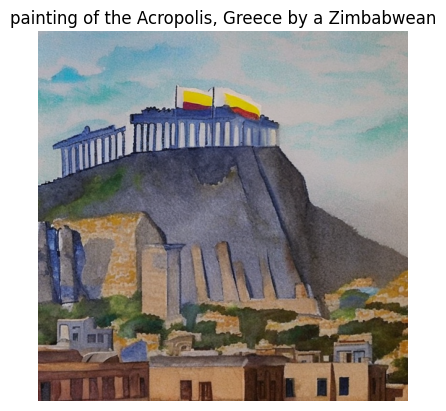

In [6]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("jpawan33/kag100-image-captioning-dataset")
train_dataset = dataset['train']

# Load the first example
example = train_dataset[0]

# Access image and caption
img = example['image']  # This is already a PIL image
caption = example['text']

# Display the image using Matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.title(caption)
plt.show()


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

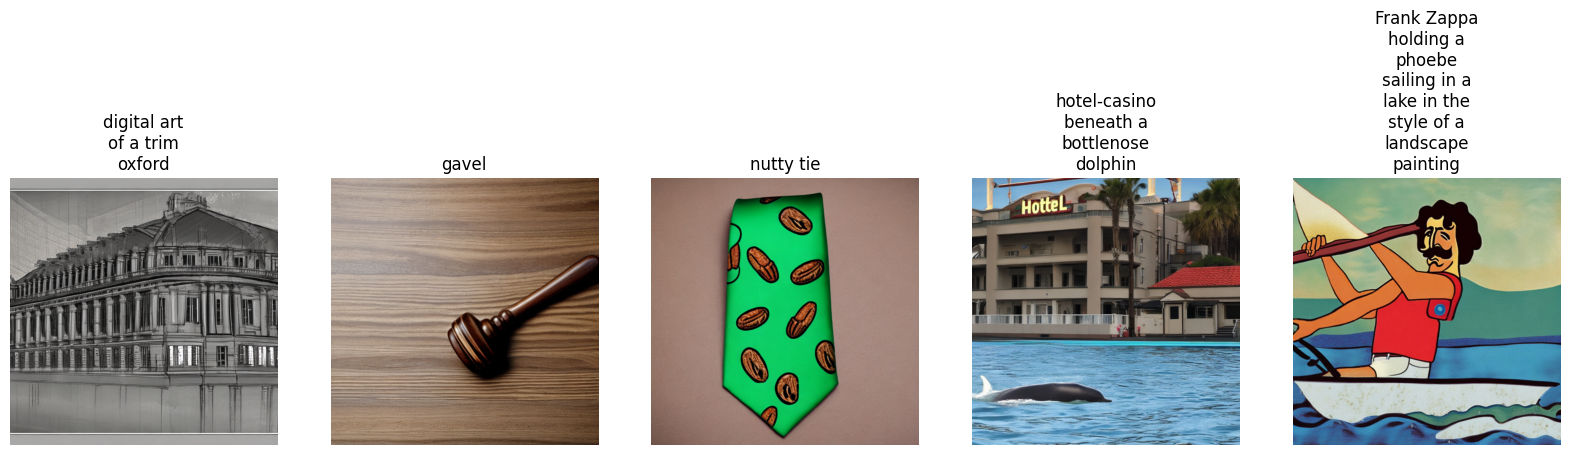

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA or MLU devices or NPU devices or certain XPU devices (with IPEX).

In [7]:
import os
os.environ['CURL_CA_BUNDLE'] = ''

import nltk
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, VisionEncoderDecoderModel, AutoTokenizer
from datasets import load_dataset
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
from evaluate import load
from transformers import TrainingArguments, Trainer
from transformers import get_scheduler
from tqdm.auto import tqdm

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add a new padding token
tokenizer.pad_token = '[PAD]'  # Set the padding token to the new token
ignore_pad_token_for_loss = True

wer = load("wer")

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]

    inputs = image_processor(images=images, return_tensors="pt")
    labels = tokenizer(captions, padding="max_length", max_length=128, truncation=True, return_tensors="pt").input_ids

    inputs.update({"labels": labels})
    return inputs

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]

    logits = logits.argmax(-1)
    if ignore_pad_token_for_loss:
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = tokenizer.batch_decode(logits, skip_special_tokens=True)

    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

ds = load_dataset("jpawan33/kag100-image-captioning-dataset")
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

# Use Swin Transformer as encoder and BERT as decoder
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "microsoft/swin-tiny-patch4-window7-224", "bert-base-uncased"
)

model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.gradient_checkpointing = True  # Enable gradient checkpointing

model = model.to(device)

model_name = "Swin-BERT"
training_args = TrainingArguments(
    output_dir=f"{model_name}-kag100",
    learning_rate=5e-5,
    num_train_epochs=200,
    fp16=True,
    fp16_full_eval=True,
    per_device_train_batch_size=1,  # Reduce batch size
    per_device_eval_batch_size=1,  # Reduce batch size
    gradient_accumulation_steps=8,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=200,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

num_epochs = training_args.num_train_epochs
num_training_steps = num_epochs * len(train_ds) // training_args.per_device_train_batch_size // training_args.gradient_accumulation_steps
num_warmup_steps = int(0.1 * num_training_steps)

optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(total=len(train_ds), desc=f"Epoch {epoch + 1}/{num_epochs}")
    total_loss = 0
    for step, batch in enumerate(train_ds):
        pixel_values = batch["pixel_values"]
        if pixel_values.dim() == 3:
            pixel_values = pixel_values.unsqueeze(0)  # Add a batch dimension

        # Ensure labels have a batch dimension
        labels = batch["labels"]
        labels = labels.to(device)
        if labels.dim() == 1:
            labels = labels.unsqueeze(0)  

        # Create the attention_mask
        attention_mask = (labels != tokenizer.pad_token_id).long()

        pixel_values = pixel_values.to(device, non_blocking=True).half()  # Cast to half-precision
        with torch.cuda.amp.autocast():
            # Pass the attention_mask to the model
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()

        # Cast gradients to FP32 before unscaling
        for param in model.parameters():
            if param.grad is not None:
                param.grad.data = param.grad.data.float()

        if (step + 1) % training_args.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (step + 1))
        progress_bar.update(1)

    progress_bar.close()
    model.eval()
    eval_metrics = trainer.evaluate()
    print(f"Epoch {epoch + 1}/{num_epochs}")


trainer.save_model(f"{model_name}-best")
